In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.sparse import diags, eye, kron, lil_matrix
from scipy.sparse.linalg import spsolve

---
# 1. Finite differences approximation

---
# 3. 2D Elliptic PDEs

**Exercise 1.** Consider the **9-point Laplacian approximation**.

* (a) Obtain its **local truncation error** by using Taylor expansions.

In [2]:
# made on paper

* (b) Modify your 2D Poisson solver to use the 9-point finite difference Laplacian instead of the standard 5-point stencil

In [6]:
def solve_dirichlet_laplacian_9pt(a, b, c, d,
                                  m_x, m_y,
                                  g_left, g_right,
                                  g_bottom, g_top,
                                  rhs=None):
    """Solver of the 2D Poisson equation with Dirichlet boundary conditions with 9points scheme.
    Here m_x==m_y"""
    if m_x <= 0 or m_y <= 0:
        raise ValueError("m_x y m_y deben ser enteros positivos.")

    h_x = (b - a) / (m_x + 1)
    h_y = (d - c) / (m_y + 1)
    if not np.isclose(h_x, h_y):
        raise ValueError("El esquema de 9 puntos requiere malla uniforme: h_x = h_y.")
    h = h_x

    x = np.linspace(a, b, m_x + 2)
    y = np.linspace(c, d, m_y + 2)
    X, Y = np.meshgrid(x, y, indexing="xy")

    x_int = x[1:-1]
    y_int = y[1:-1]
    XI, YI = np.meshgrid(x_int, y_int, indexing="xy")

    if rhs is None:
        F_mat = np.zeros((m_y, m_x), dtype=float)
        rhs_callable = None
    elif callable(rhs):
        F_mat = np.empty((m_y, m_x), dtype=float)
        for jj in range(m_y):
            for ii in range(m_x):
                F_mat[jj, ii] = rhs(XI[jj, ii], YI[jj, ii])
        rhs_callable = rhs
    else:
        rhs_arr = np.asarray(rhs, dtype=float)
        if rhs_arr.shape != (m_y, m_x):
            raise ValueError("El término derecho debe tener la forma (m_y, m_x).")
        F_mat = rhs_arr
        rhs_callable = None

    def boundary_values(data, points):
        if callable(data):
            return np.asarray([data(p) for p in points], dtype=float)
        arr = np.asarray(data, dtype=float)
        if arr.ndim == 0:
            return np.full(points.shape, arr, dtype=float)
        if arr.shape != points.shape:
            raise ValueError("Los datos de contorno no coinciden con la malla.")
        return arr

    left_boundary = boundary_values(g_left, y)
    right_boundary = boundary_values(g_right, y)
    bottom_boundary = boundary_values(g_bottom, x)
    top_boundary = boundary_values(g_top, x)

    scale = 1.0 / (6.0 * h * h)
    main_coeff = -20.0 * scale
    cross_coeff = 4.0 * scale
    diag_coeff = 1.0 * scale

    n_unknowns = m_x * m_y
    A = lil_matrix((n_unknowns, n_unknowns), dtype=float)
    F_vec = np.zeros(n_unknowns, dtype=float)

    for j in range(1, m_y + 1):
        for i in range(1, m_x + 1):
            k = (j - 1) * m_x + (i - 1)

            rhs_val = F_mat[j - 1, i - 1]
            if rhs_callable is not None:
                xi = x[i]
                yj = y[j]
                f0 = rhs_callable(xi, yj)
                f_xm = rhs_callable(x[i - 1], yj)
                f_xp = rhs_callable(x[i + 1], yj)
                f_ym = rhs_callable(xi, y[j - 1])
                f_yp = rhs_callable(xi, y[j + 1])
                lap_f = (f_xm + f_xp - 2.0 * f0) / (h * h)
                lap_f += (f_ym + f_yp - 2.0 * f0) / (h * h)
                rhs_val = f0 + (h * h) / 12.0 * lap_f

            A[k, k] = main_coeff

            if i > 1:
                A[k, k - 1] = cross_coeff
            else:
                rhs_val -= cross_coeff * left_boundary[j]

            if i < m_x:
                A[k, k + 1] = cross_coeff
            else:
                rhs_val -= cross_coeff * right_boundary[j]

            if j > 1:
                A[k, k - m_x] = cross_coeff
            else:
                rhs_val -= cross_coeff * bottom_boundary[i]

            if j < m_y:
                A[k, k + m_x] = cross_coeff
            else:
                rhs_val -= cross_coeff * top_boundary[i]

            if i > 1 and j > 1:
                A[k, k - m_x - 1] = diag_coeff
            else:
                if i == 1 and j == 1:
                    bc_val = 0.5 * (left_boundary[0] + bottom_boundary[0])
                elif i == 1:
                    bc_val = left_boundary[j - 1]
                else:
                    bc_val = bottom_boundary[i - 1]
                rhs_val -= diag_coeff * bc_val

            if i < m_x and j > 1:
                A[k, k - m_x + 1] = diag_coeff
            else:
                if i == m_x and j == 1:
                    bc_val = 0.5 * (right_boundary[0] + bottom_boundary[-1])
                elif i == m_x:
                    bc_val = right_boundary[j - 1]
                else:
                    bc_val = bottom_boundary[i + 1]
                rhs_val -= diag_coeff * bc_val

            if i > 1 and j < m_y:
                A[k, k + m_x - 1] = diag_coeff
            else:
                if i == 1 and j == m_y:
                    bc_val = 0.5 * (left_boundary[-1] + top_boundary[0])
                elif i == 1:
                    bc_val = left_boundary[j + 1]
                else:
                    bc_val = top_boundary[i - 1]
                rhs_val -= diag_coeff * bc_val

            if i < m_x and j < m_y:
                A[k, k + m_x + 1] = diag_coeff
            else:
                if i == m_x and j == m_y:
                    bc_val = 0.5 * (right_boundary[-1] + top_boundary[-1])
                elif i == m_x:
                    bc_val = right_boundary[j + 1]
                else:
                    bc_val = top_boundary[i + 1]
                rhs_val -= diag_coeff * bc_val

            F_vec[k] = rhs_val

    A_csr = A.tocsr()
    U_int = spsolve(A_csr, F_vec).reshape((m_y, m_x))

    U = np.zeros((m_y + 2, m_x + 2), dtype=float)
    U[1:-1, 1:-1] = U_int
    U[0, :] = bottom_boundary
    U[-1, :] = top_boundary
    U[:, 0] = left_boundary
    U[:, -1] = right_boundary

    return X, Y, U

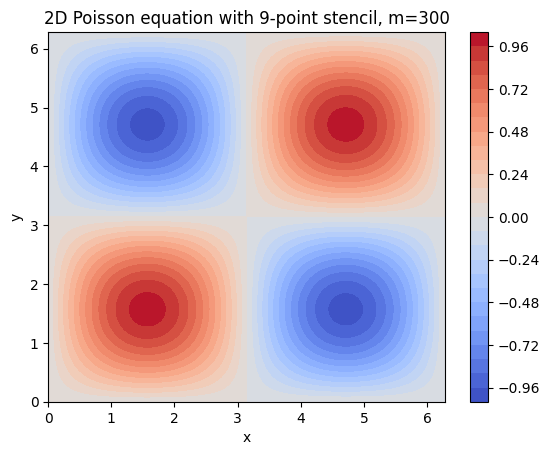

In [8]:
m = 300
X, Y, U = solve_dirichlet_laplacian_9pt(a=0, b=2*np.pi, c=0, d=2*np.pi,
                                        m_x=m, m_y=m,
                                        g_left=lambda y: 0,
                                        g_right=lambda y: 0,
                                        g_bottom=lambda x: 0,
                                        g_top=lambda x: 0,
                                        rhs=lambda x, y: -2*np.sin(x)*np.sin(y))

plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title(f'2D Poisson equation with 9-point stencil, m={m}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

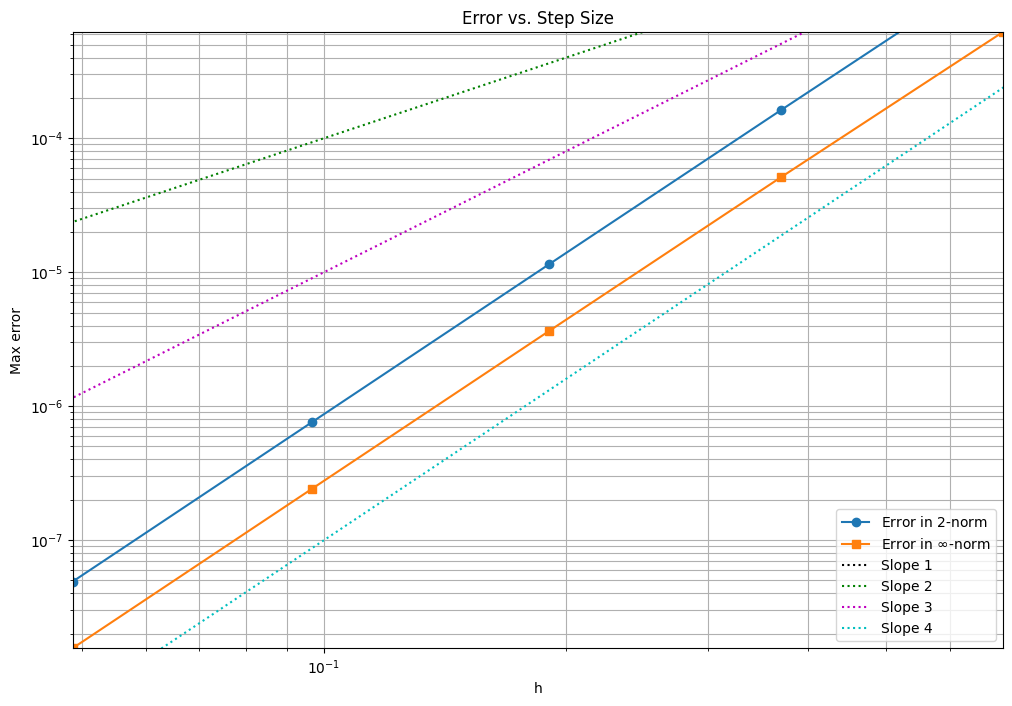

In [27]:
m_list = [8, 16, 32, 64, 128]

errors2 = []
errorsinf = []
hs = []

for m in m_list:
    X, Y, U_it = solve_dirichlet_laplacian_9pt(a=0, b=2*np.pi, c=0, d=2*np.pi,
                                        m_x=m, m_y=m,
                                        g_left=lambda y: 0,
                                        g_right=lambda y: 0,
                                        g_bottom=lambda x: 0,
                                        g_top=lambda x: 0,
                                        rhs=lambda x, y: -2*np.sin(x)*np.sin(y))
    h = (2*np.pi)/(m+1)
    E = U_it - np.sin(X)*np.sin(Y)
    
    errorinf = np.max(np.abs(E))          
    error2 = np.linalg.norm(E.ravel(), 2) * h

    errors2.append(error2)
    errorsinf.append(errorinf)
    hs.append(h)

hvec = 1.0 / 2**np.arange(30)

plt.figure(figsize=(12, 8))
plt.loglog(hs, errors2, marker='o', label=r"Error in $2$-norm")
plt.loglog(hs, errorsinf, marker='s', label=r"Error in $\infty$-norm")
plt.loglog(hvec, 0.1*hvec**1, 'k:', label="Slope 1")
plt.loglog(hvec, 0.01*hvec**2, 'g:', label="Slope 2")
plt.loglog(hvec, 0.01*hvec**3, 'm:', label="Slope 3")
plt.loglog(hvec, 0.001*hvec**4, 'c:', label="Slope 4")
plt.xlim([min(hs), max(hs)])
plt.ylim([min(errorsinf), max(errorsinf)])
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Error vs. Step Size')
plt.legend()
plt.grid(True, which='both')

---
**Exercise 2.** Consider the **Laplace equation**

$$
\begin{aligned}
\Delta u + \lambda u &= 0, & 0 < x, y < 1, \
u &= 0, & \text{on the boundaries}.
\end{aligned}
$$

* (a) Show that the **eigenvalues and eigenvectors** for this problem are

$$
\lambda_{k, l} = \pi^2 (l^2 + k^2), \quad l, k = 1, 2, \dots,
$$
$$
u_{k, l}(x, y) = \sin(k \pi x) \sin(l \pi y).
$$

* (b) Show that the standard central finite difference scheme using the five-point stencil is stable for the **Poisson equation**.

  *Hint: The eigenvectors for $\mathbf{A}^h \mathbf{U}^h = \mathbf{F}$ (eigen-grid functions) are*

  $$
  v_{p, q}^{ij} = \sin(p \pi h) \sin(q \pi h),
  \quad i, j, p, q = 1, 2, \dots, m.
  $$

  *Moreover, remember that*
  $$
  | (\mathbf{A}^h)^{-1} |_2 = \frac{1}{\min |\lambda_i (\mathbf{A}^h)|}.
  $$


---
**Exercise 3.** Write down the **coefficient matrix** of the finite difference method using the standard central five-point stencil for the Poisson equation defined on the rectangle $[a, b] \times [c, d]$. Take $m=n=3$ and assume a **Dirichlet boundary condition** at $x=a$, $y=c$ and $y=d$, and a **Neumann boundary condition** $\partial u / \partial n = g(y)$ at $x=b$. Use the **ghost point method** to deal with the Neumann boundary condition.

In [3]:
from tests.test_5lap_robin import solve_poisson_5pt_mixed

In [13]:
# Mixta: Neumann en arriba/abajo (g=0), Dirichlet en izquierda/derecha
m=300
left  = ('D', lambda y: 0.0)
right = ('D', lambda y: 0.0)
bottom= ('N', 0.0)
top   = ('N', 0.0)
X,Y,U = solve_poisson_5pt_mixed(a=0, b=2*np.pi, c=0, d=2*np.pi, 
                                m_x=64, m_y=64, 
                                left_bc=left, right_bc=right, 
                                bottom_bc=bottom, top_bc=top,
                                rhs=lambda X,Y: -2*np.sin(X)*np.sin(Y),
                                reference_value=None) 

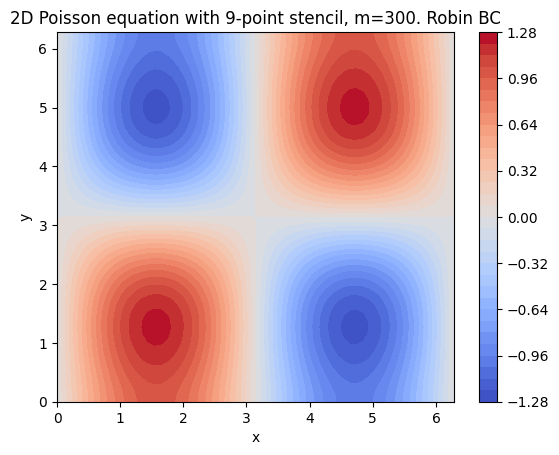

In [14]:
plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title(f'2D Poisson equation with 9-point stencil, m={m}. Robin BC')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

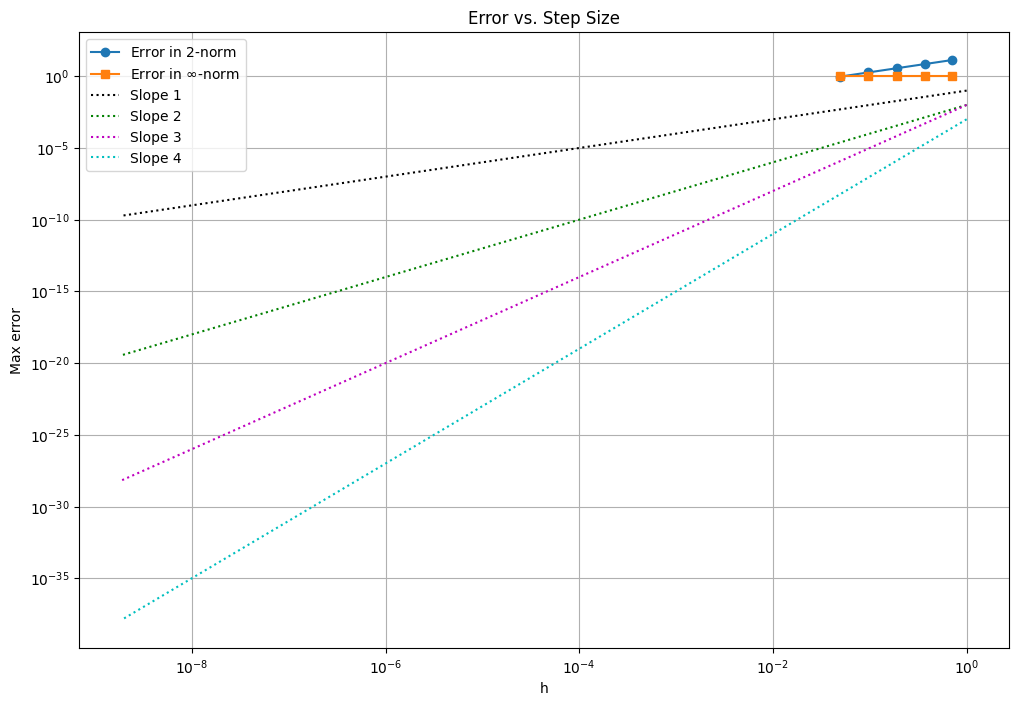

In [15]:
m_list = [8, 16, 32, 64, 128]

errors2 = []
errorsinf = []
hs = []

for m in m_list:
    X, Y, U_it = solve_poisson_5pt_mixed(a=0, b=2*np.pi, c=0, d=2*np.pi, 
                                m_x=64, m_y=64, 
                                left_bc=left, right_bc=right, 
                                bottom_bc=bottom, top_bc=top,
                                rhs=lambda X,Y: -2*np.sin(X)*np.sin(Y),
                                reference_value=None) 
    h = (2*np.pi)/(m+1)
    E = U_it - np.sin(X)*np.sin(Y)
    
    errorinf = np.max(np.abs(E))          
    error2 = np.linalg.norm(E.ravel(), 2) * h

    errors2.append(error2)
    errorsinf.append(errorinf)
    hs.append(h)

hvec = 1.0 / 2**np.arange(30)
plt.figure(figsize=(12, 8))
plt.loglog(hs, errors2, marker='o', label=r"Error in $2$-norm")
plt.loglog(hs, errorsinf, marker='s', label=r"Error in $\infty$-norm")
plt.loglog(hvec, 0.1*hvec**1, 'k:', label="Slope 1")
plt.loglog(hvec, 0.01*hvec**2, 'g:', label="Slope 2")
plt.loglog(hvec, 0.01*hvec**3, 'm:', label="Slope 3")
plt.loglog(hvec, 0.001*hvec**4, 'c:', label="Slope 4")
#plt.xlim([min(hs), max(hs)])
#plt.ylim([min(errorsinf), max(errorsinf)])
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Error vs. Step Size')
plt.legend()
plt.grid(True, which='both')

---
**Exercise 4.** Write a solver for the **Laplace equation**

$$
\begin{aligned}
\frac{1}{r} \frac{\partial}{\partial r} \left(r \frac{\partial u}{\partial r}\right) + \frac{1}{r^2} \frac{\partial^2 u}{\partial \theta^2} &= 0, & 0 < r < 1,\, 0 < \theta < 2\pi, \,
  u(r, \theta) &= u(r, \theta + 2\pi), & 0 \le r \le 1, \,
  |u(r, \theta)| &< \infty, & \forall (r, \theta) \in \Omega, \,
  u(1, \theta) &= g(\theta), & 0 \le \theta < 2\pi.
  \end{aligned}
  $$

As a check, consider a numerical test to analyze the **convergence**, i.e. choose $g(\theta)$ as you wish and do a **grid refinement study**.

Remember that the general solution to this problem is

$$
u(r, \theta) = \sum_{n=0}^\infty A_n \cos(n \theta) r^n + \sum_{n=1}^\infty B_n \sin(n \theta) r^n.
$$

In [ ]:
from tests.test_5lap_polars import solve_polar_poisson_5pt

# test
left  = ('D', lambda y: 0.0)
right = ('D', lambda y: 0.0)
bottom= ('N', 0.0)
top   = ('N', 0.0)

m=300
X,Y,U = solve_polar_poisson_5pt(R1 =0.0, R2=1.0,
                                m_r=m, m_theta=m,
                                f=0,
                                g_outer=0
                                g_inner=0,
                                theta0=0.0, thetamax=2*np.pi
                                )

NameError: name 'solve_dirichlet_laplacian_5pt_polar' is not defined

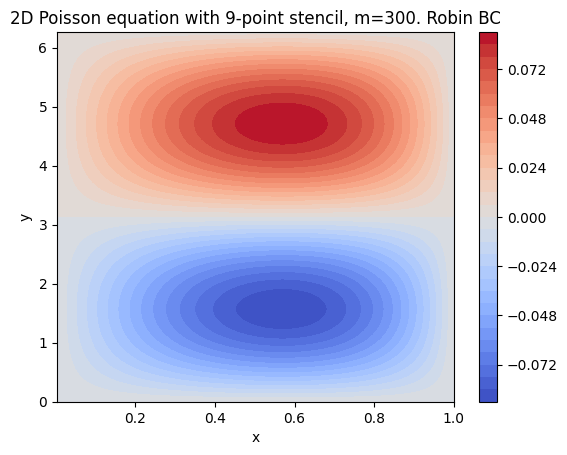

In [11]:
plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title(f'2D Poisson equation with 9-point stencil, m={m}. Robin BC')
plt.xlabel('x')
plt.ylabel('y')
plt.show()